In [2]:
from data_sampling import verify_samples
import pandas as pd

#verify_samples()

batch_size = 4096
STROKE_COUNT = 196
TRAIN_SAMPLES = 750
VALID_SAMPLES = 75
TEST_SAMPLES = 50

# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

def get_available_gpus():
    from tensorflow.python.client import device_lib
    return device_lib.list_local_devices()
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

In [4]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from keras.metrics import top_k_categorical_accuracy
def top_3_accuracy(x,y): return top_k_categorical_accuracy(x,y, 3)
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from glob import glob
import gc
gc.enable()

Using TensorFlow backend.


In [5]:
from ast import literal_eval
*FILES, = filter(lambda x:x[0]!='.',os.listdir('train_sampled'))
COL_NAMES = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']

def _stack_it(raw_strokes):
    stroke_vec = literal_eval(raw_strokes) # string->list
    in_strokes = [(xi,yi,i)  
     for i,(x,y) in enumerate(stroke_vec) 
     for xi,yi in zip(x,y)]
    c_strokes = np.stack(in_strokes)
    c_strokes[:,2] = [1]+np.diff(c_strokes[:,2]).tolist()
    c_strokes[:,2] += 1
    return pad_sequences(c_strokes.swapaxes(0, 1), 
                         maxlen=STROKE_COUNT, 
                         padding='post').swapaxes(0, 1)

def read_batch(base, files):
    out_df_list = []
    for c_path in files:
        c_path = os.path.join(base, c_path)
        c_df = pd.read_csv(c_path, engine='python')
        c_df.columns=COL_NAMES
        out_df_list += [c_df[['drawing', 'word']]]
    full_df = pd.concat(out_df_list)
    full_df['drawing'] = full_df['drawing'].\
        map(_stack_it)
    
    return full_df

In [6]:
train_df = read_batch('train_sampled',FILES)
valid_df = read_batch('valid_sampled',FILES)
test_df = read_batch('test_sampled',FILES)
word_encoder = LabelEncoder()
word_encoder.fit(train_df['word'])

LabelEncoder()

In [7]:
def get_Xy(in_df):
    X = np.stack(in_df['drawing'], 0)
    y = to_categorical(word_encoder.transform(in_df['word'].values))
    return X, y
train_X, train_y = get_Xy(train_df)
valid_X, valid_y = get_Xy(valid_df)
test_X, test_y = get_Xy(test_df)
print(train_X.shape)

(100000, 196, 3)


In [9]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv1D, LSTM, Dense, Dropout
stroke_read_model = Sequential()
stroke_read_model.add(BatchNormalization(input_shape = (None,)+train_X.shape[2:]))
# filter count and length are taken from the script https://github.com/tensorflow/models/blob/master/tutorials/rnn/quickdraw/train_model.py
# stroke_read_model.add(Conv1D(48, (5,)))
# stroke_read_model.add(Dropout(0.3))
# stroke_read_model.add(Conv1D(64, (5,)))
# stroke_read_model.add(Dropout(0.3))
# stroke_read_model.add(Conv1D(96, (3,)))
# stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(64, return_sequences = True))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(LSTM(64, return_sequences = False))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(256))
stroke_read_model.add(Dropout(0.3))
stroke_read_model.add(Dense(len(word_encoder.classes_), activation = 'softmax'))
stroke_read_model.compile(optimizer = 'adam', 
                          loss = 'categorical_crossentropy', 
                          metrics = ['categorical_accuracy', top_3_accuracy])
stroke_read_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, None, 3)           12        
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          17408     
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
__________

In [11]:
weight_path="{}_weights.best.hdf5".format('stroke_lstm_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, 
                                   verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [12]:
import time
from IPython.display import clear_output
t_start = time.time()
stroke_read_model.fit(train_X, train_y,
                      validation_data = (valid_X, valid_y), 
                      batch_size = batch_size,
                      epochs = 1,
                      callbacks = callbacks_list)
clear_output()
t_end = time.time()
print('Train finished with',t_end-t_start,'second(s)')

Train finished with 399.3058400154114 second(s)


In [13]:
stroke_read_model.load_weights(weight_path)
lstm_results = stroke_read_model.evaluate(test_X, test_y, batch_size = 4096)
print('Accuracy: %2.1f%%, Top 3 Accuracy %2.1f%%' % (100*lstm_results[1], 100*lstm_results[2]))

10000/10000 [==============================] - 13s 1ms/step
Accuracy: 1.1%, Top 3 Accuracy 3.2%


                  precision    recall  f1-score   support

        airplane       0.00      0.00      0.00       100
     alarm clock       0.00      0.00      0.00       100
       ambulance       0.00      0.00      0.00       100
           angel       0.00      0.00      0.00       100
animal migration       0.00      0.00      0.00       100
             ant       0.00      0.00      0.00       100
           anvil       0.00      0.00      0.00       100
           apple       0.00      0.00      0.00       100
             arm       0.00      0.00      0.00       100
       asparagus       0.00      0.00      0.00       100
             axe       0.00      0.00      0.00       100
        backpack       0.00      0.00      0.00       100
          banana       0.00      0.00      0.00       100
         bandage       0.00      0.00      0.00       100
            barn       0.00      0.00      0.00       100
        baseball       0.00      0.00      0.00       100
    baseball 

/home/reactlover_eiei/downloads/.bashrc/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


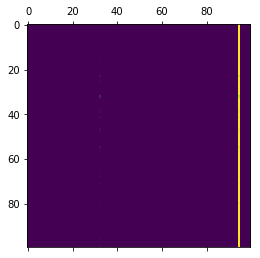

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
test_cat = np.argmax(test_y, 1)
pred_y = stroke_read_model.predict(test_X, batch_size = 4096)
pred_cat = np.argmax(pred_y, 1)
plt.matshow(confusion_matrix(test_cat, pred_cat))
print(classification_report(test_cat, pred_cat, 
                            target_names = [x for x in word_encoder.classes_]))